## [ECCV 2022] Spatial-Separated Curve Rendering Network for Efficient and High-Resolution Image Harmonization

Jingtang Liang 🧑‍💻 , Xiaodong Cun 🧑‍💻 , Chi-Man Pun, Jue Wang

> We have tested these code in Ubuntu 18.04 w/ GPU and Macbook Arm w/ M1 CPU. 
> Our method can run 10 example images around 10s in CPU (Macbook Air w/ M1)!

#### Environment setup
our method can run smoothly under the requirement of recently version of `torch, torchvision, numpy, Pillow`.

or install necessary package by `pip install -r requirements.txt`
`


total Dataset of is : 10
train: 10 mask: 10 anno: 10
stack: True


/Users/shadowcun/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/shadowcun/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


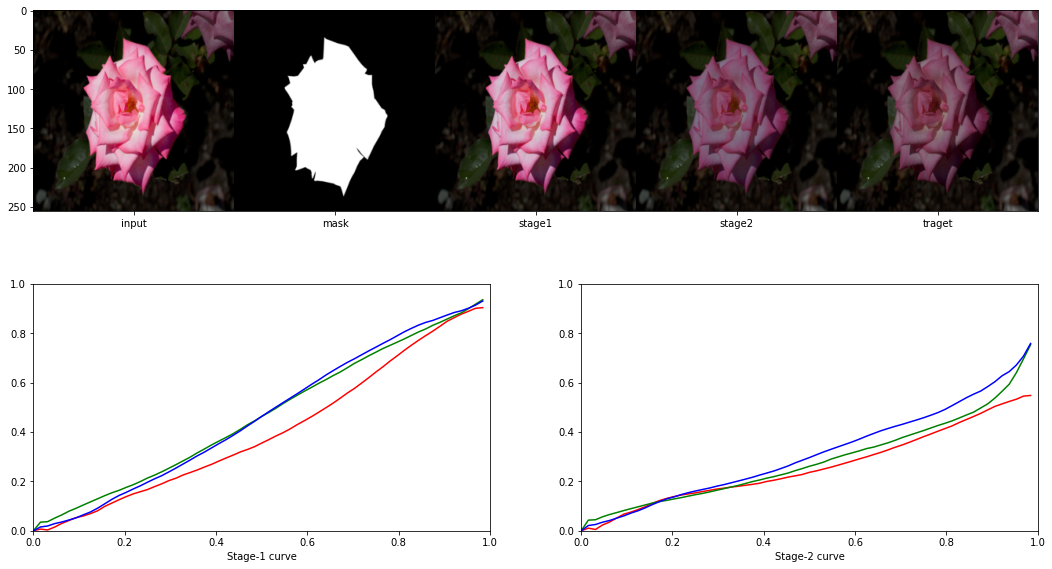

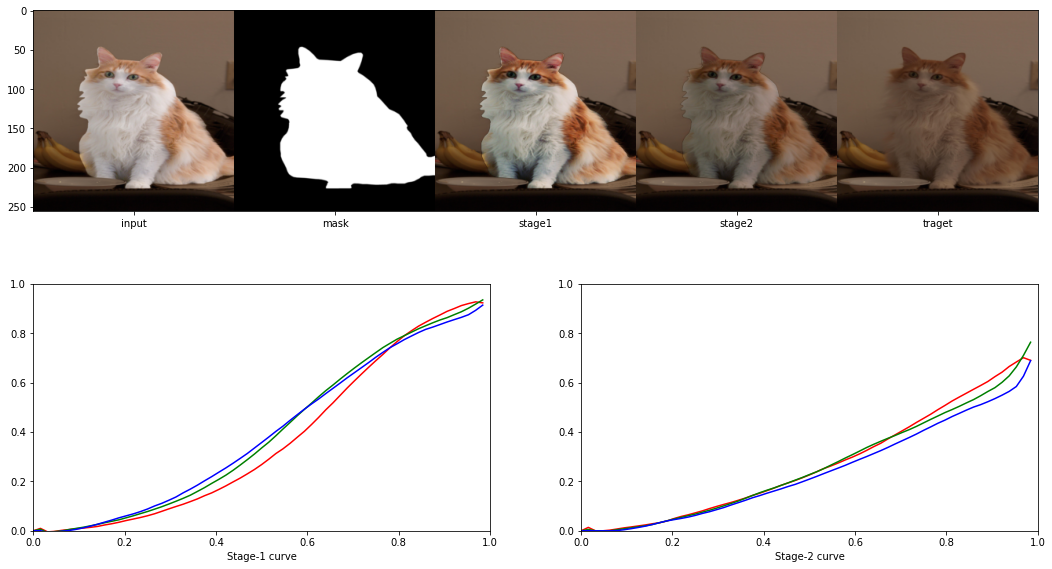

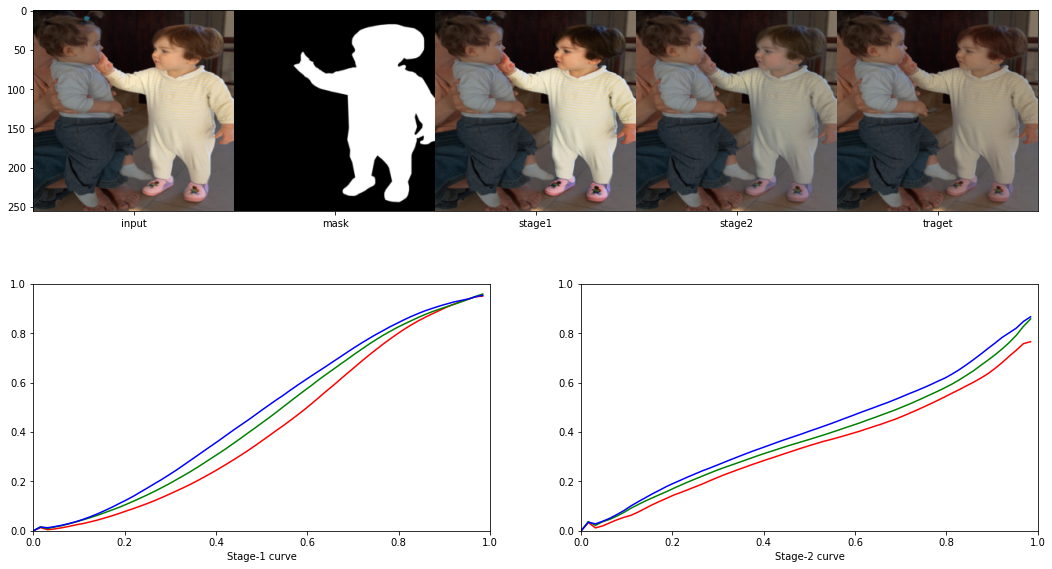

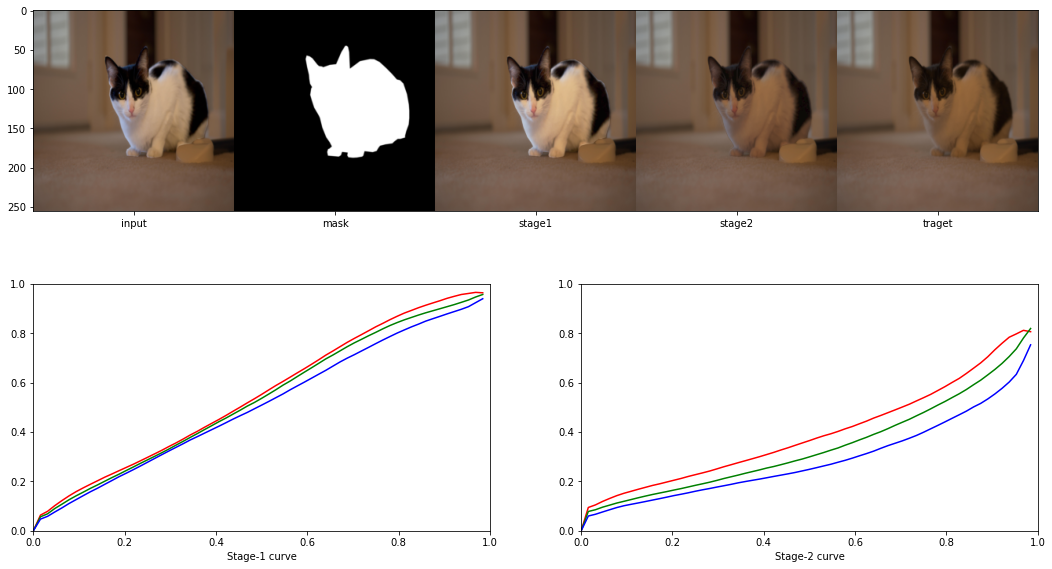

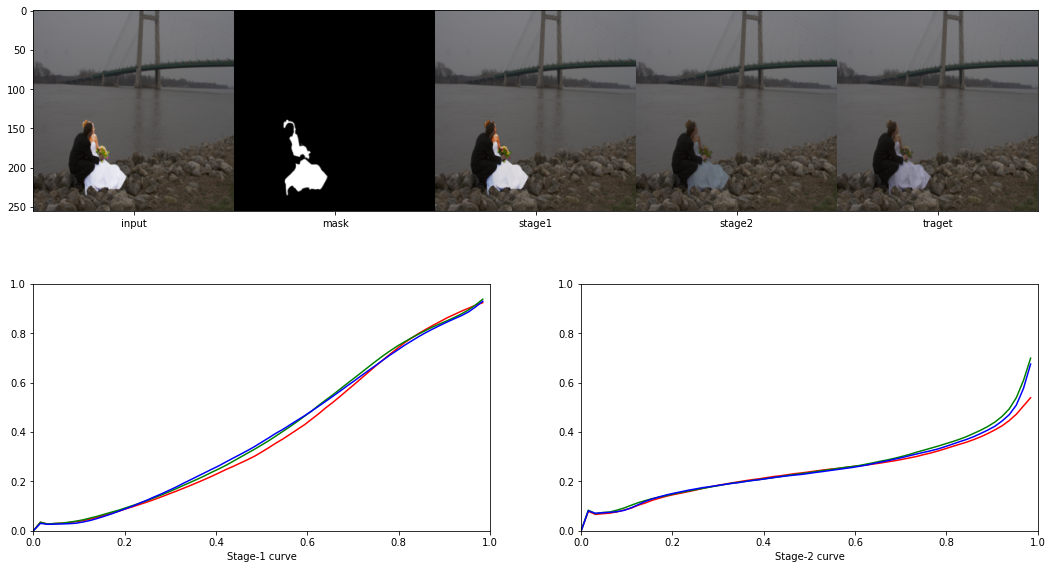

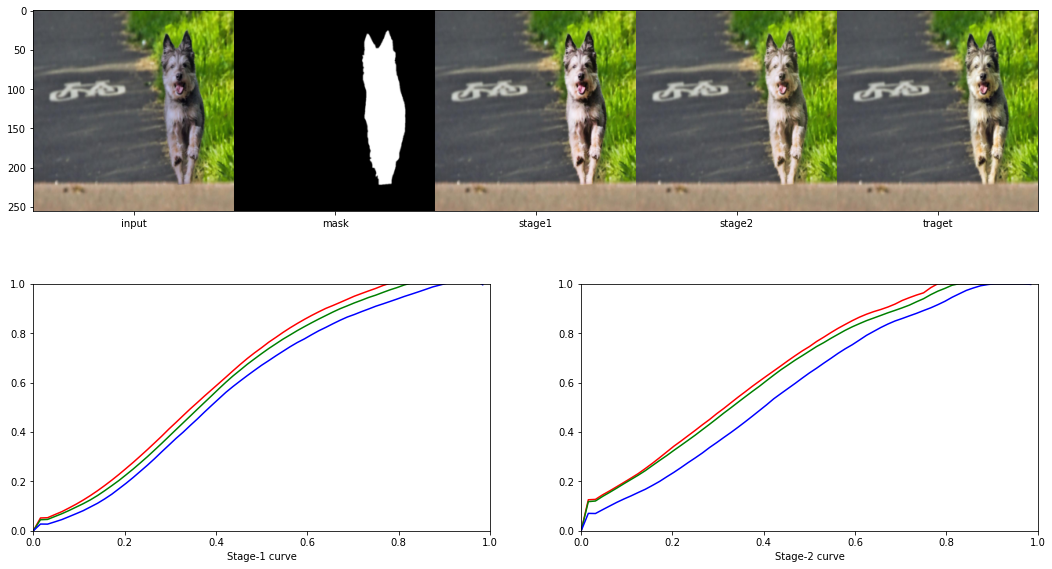

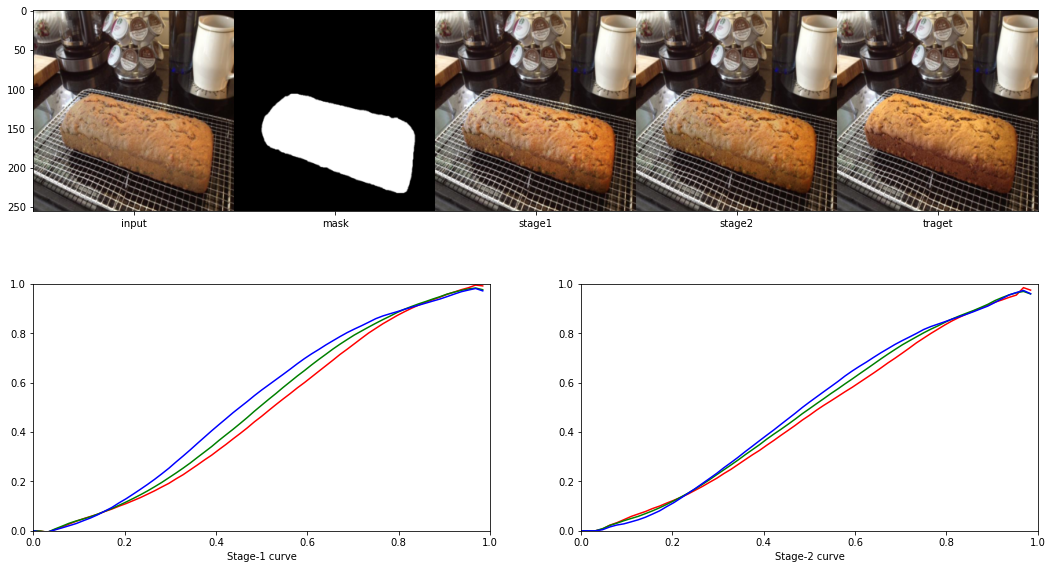

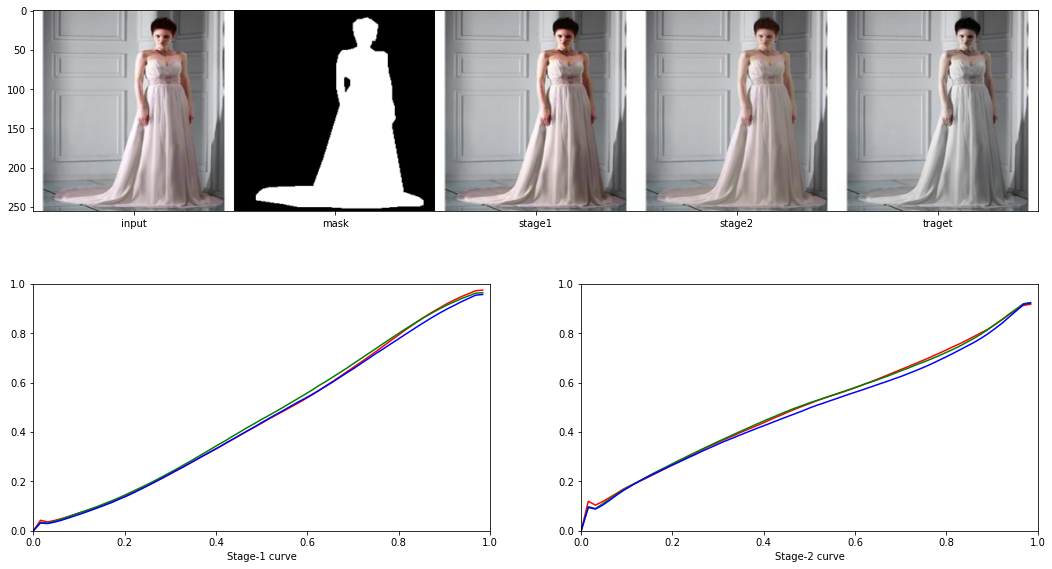

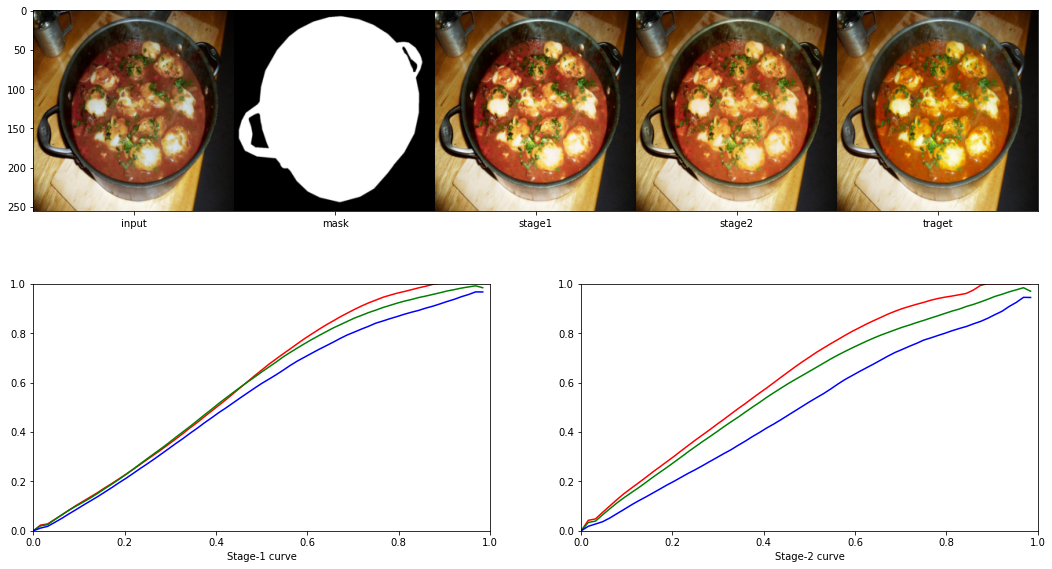

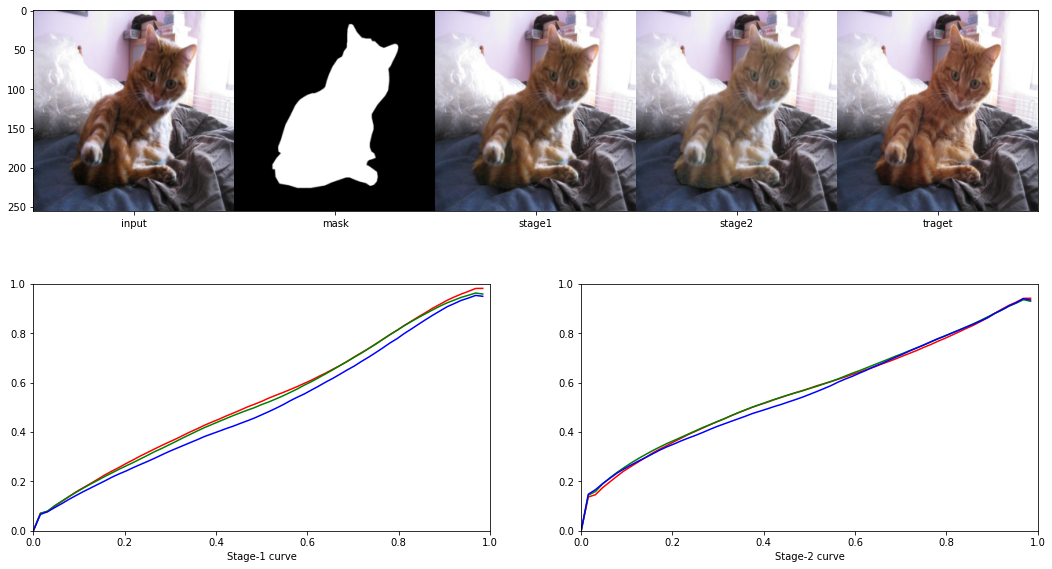

In [1]:
import torch
import numpy as np
from dataset import HarmonizationDataset
from models import S2CRNet,CF
from torchvision.models import squeezenet1_1
from utils import im_to_numpy

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#########[settings]############## 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#########[setttings for dataset ]
val_loader = torch.utils.data.DataLoader(HarmonizationDataset('sample_dataset'), batch_size=1, shuffle=False,
                                             num_workers=1, pin_memory=False, drop_last=True)


#############[create and load pretrained model]#############################
model = S2CRNet(squeezenet1_1(pretrained=False), stack=True).to(device)
model.load_state_dict(torch.load('S2CRNet_pretrained.pth',map_location=device)['state_dict'])

with torch.no_grad():
    for i, batches in enumerate(val_loader):
        inputs = batches['composite_images'].to(device)
        target = batches['real_images'].to(device)
        mask = batches['mask'].to(device)
        fore = batches["fore_images"].to(device) 
        foremask = batches["fore_mask"].to(device) 
        label = batches['label']
        ori_img = batches["ori_img"].to(device)

        # creating the one-hot semantic label of the foreground object
        label_oh = torch.zeros(1, 5).scatter_(1, label.view(label.shape[0], 1), 1).to(
            torch.float32).to(device)

        feeded = torch.cat([inputs, mask], dim=1).to(device)
        fore = torch.cat([fore, foremask], dim=1).to(device)
        
        ### model forward
        outputs, param1, param2 = model(ori_img, feeded, fore, label_oh, True)

        im_stage1 = outputs[1] * mask + target * (1 - mask)
        im_stage2 = outputs[0] * mask + target * (1 - mask)


        ########### concat images and show the results
        imall = torch.cat([inputs,mask.repeat(1,3,1,1), im_stage1, im_stage2, target],dim=3)
        imfinal = im_to_numpy(torch.clamp(imall[0] * 255, min=0.0, max=255.0)).astype(np.uint8)
        
        gs = gridspec.GridSpec(2,2)
        fig = plt.figure(figsize=(18,10))

        ax1 = fig.add_subplot(gs[0, :])
        ax1.imshow(imfinal)
        plt.xticks(128+np.arange(5)*256,['input','mask','stage1','stage2','traget'] )
        
        xx = np.arange(0,1,1/64)
        yy = torch.from_numpy(xx).view(1,1,1,64).repeat(1,3,1,1).to(device)
        
        ### plot the intensity mappings
        ax2 = fig.add_subplot(gs[1, 0])
        yy = CF(yy,param1.view(1,3,1,1,64),64)
        ax2.plot(xx,yy[0,0,0].cpu(),'r')
        ax2.plot(xx,yy[0,1,0].cpu(),'g')
        ax2.plot(xx,yy[0,2,0].cpu(),'b')
        plt.xlabel('Stage-1 curve')
        plt.xlim(0,1)
        plt.ylim(0,1)
        
        ax3 = fig.add_subplot(gs[1, 1])
        yy = CF(yy,param2.view(1,3,1,1,64),64)
        ax3.plot(xx,yy[0,0,0].cpu(),'r')
        ax3.plot(xx,yy[0,1,0].cpu(),'g')
        ax3.plot(xx,yy[0,2,0].cpu(),'b')
        plt.xlabel('Stage-2 curve')
        plt.xlim(0,1)
        plt.ylim(0,1)

    